In [38]:
import pandas as pd
import numpy as np
import pickle

In [39]:
df = pd.concat(chunk for chunk in pd.read_csv("HistoricTariffs-2018-05-20.csv", 
                                              chunksize=10**5,
                                              sep = '\t',
                                              low_memory=False
                                             )
              )

In [67]:
def train_model(input_df):
    trained_data = {}
    uniq_region = {}
    for col_name in input_df.columns.values:
        if input_df.dtypes[col_name] ==  'object' or input_df.dtypes[col_name] ==  'bool':
            values_to_train = pd.DataFrame(input_df[col_name].drop_duplicates())
            for i in values_to_train:
                trained_data[col_name] = list(values_to_train[i])
    
    uniq_region=input_df[['Region','RegionID']].drop_duplicates()
    uniq_region.set_index("Region", drop=True, inplace=True)
    uniq_region=uniq_region.to_dict()['RegionID']
    return trained_data,uniq_region

pickle.dump(train_model(df), 
            open('trained_data.pickle', 'wb')
           )

In [40]:
def validate_date(df):
    text_cols, region_ids = pickle.load(open('trained_data.pickle', 'rb'))
    for col_name, values in text_cols.items():
        trained_data = pd.DataFrame(values).rename(columns={0:col_name})
        matched_values = pd.merge(trained_data, 
                                  pd.DataFrame(df[col_name]), 
                                  on=[col_name], how='right', 
                                  indicator='Exist')
        matched_values['Exist'] = np.where(matched_values.Exist == 'both', True, False)
        if len(matched_values.index[matched_values['Exist']==True]) == len(df[col_name]):
                pass
        else:
            err_matched_values = matched_values[matched_values['Exist']==False][col_name].unique()
            print('Column:', col_name, '==>  Row Numbers:',
                      df.loc[df[col_name].isin(err_matched_values)].index.values+1)

validate_date(df)

In [56]:
df.head()
df = df.select_dtypes(exclude=['object','bool'])
#df-

df['RegionID'].min(),df['RegionID'].max()

(10, 23)

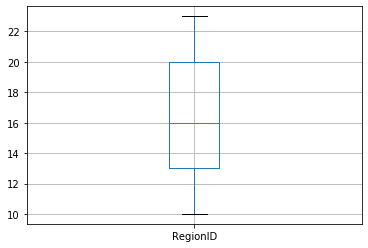

In [55]:
import seaborn as sb
df['RegionID'].plot.box(grid='True')

In [48]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df['RegionID']))
print(z)

[0.8473559  0.8473559  0.8473559  ... 1.10380535 1.10380535 1.10380535]
